# Dynamic Threshold Algorithm 4.0.1  

## Details:  
1. The improved version of 4.0.0

In [3]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import random
import datatools as dt

## Section 1: Load raw data

In [4]:
raw = dt.load_csv('data/dongguan.csv')
raw.columns = ['SY', 'FN', 'TR']
raw.head()

SY       FN        TR
Time                                            
2017-06-11 22:38:00  1.032500      NaN  0.394167
2017-06-11 22:39:00  0.992975  0.50795  0.345587
2017-06-11 22:40:00  1.044975  0.79930  0.297687
2017-06-11 22:41:00  1.149100  0.52460  0.314350
2017-06-11 22:42:00  1.147087  0.49130  0.351850

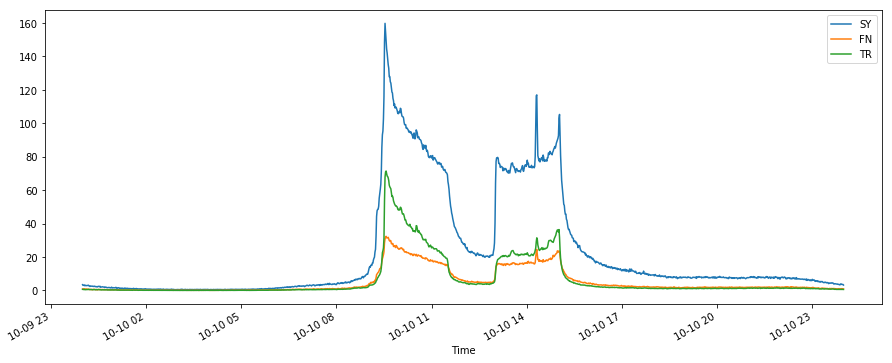

In [5]:
raw.loc['2017-10-10'].plot(figsize=(15, 6))
plt.show()

In [7]:
guoqing = dt.to_date_list(pd.date_range(start='2017-10-01',
                                        end='2017-10-08',
                                        freq='D'))

In [8]:
raw_data = dt.preprocess(raw, holiday_list=guoqing).loc['2017-10-09':]
date_list = dt.get_date_list(raw_data)

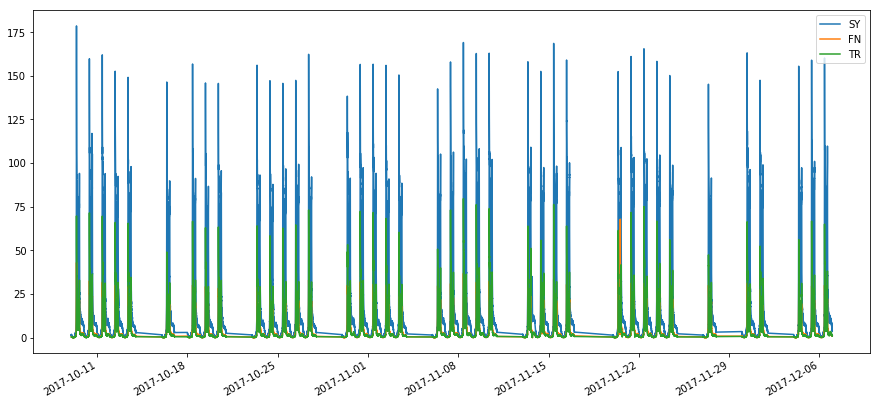

In [9]:
raw_data.plot(figsize=(15, 7))
plt.show()

## Section 2: Define functions

In [2]:
from __future__ import division, print_function

import os
import pickle
from collections import namedtuple
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PyAstronomy.pyasl.asl.outlier import generalizedESD
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.seasonal import seasonal_decompose

import datatools as dt

/home/jly/Desktop/DynamicThresholdAlgorithm4/venv/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
# version info
__version__ = '4.0.0'

# define nametuples: Lines (Dynamic Threshold), K (basic parameters), tsr(model)
Lines = namedtuple('Lines', ['baseline', 'lower_thresh', 'upper_thresh'])
K = namedtuple('K', ['kl', 'ku', 'kn'])
TSR = namedtuple('TSR', ['trend', 'seasonal', 'residual'])


def adjust_up(x, k):
    """
    Adjust upper.
    """
    return (1 + k * x / x.max()) * x


def adjust_low(x, k):
    """
    Adjust lower.
    """
    return (1 - k * x / x.max()) * x


def wash(data, method='ocs'):
    """
    Wash data first
    Method: ocs: OneClassSVM
            ifrt: IsolationForest
            lof: LocalOutlierFactor
    """
    data_re = data.reshape((-1, 1440))
    data_re_norm = dt.normalize_max(data_re)
    if method == 'lof':
        clf = LocalOutlierFactor()
        labels = clf.fit_predict(data_re_norm)
    elif method in ['ocs', 'ifrt']:
        if method == 'ocs':
            clf = svm.OneClassSVM(kernel='rbf').fit(data_re_norm)
        else:
            clf = IsolationForest().fit(data_re_norm)
        labels = clf.predict(data_re_norm)
    else:
        raise Exception(
            "Wrong method: {!r}. Choose from ['ocs', 'ifrt', 'lof']".format(method))
    return data_re[np.where(labels == 1)]


def tsr_decompose(data):
    """Decompose data."""
    result = seasonal_decompose(data.ravel(), model='additive', freq=1440)
    trend = result.trend.reshape((-1, 1440))[1:-1]
    seasonal = result.seasonal[-1440:]
    residual = noise_model(result.resid)
    return TSR(trend, seasonal, residual)


def predict_baseline(model, sm=1):
    """Predict baseline."""
    trend, seasonal, _ = model
    n = trend.shape[0]
    x = np.linspace(0, n - 1, n)[:, np.newaxis]
    clf = svm.SVR().fit(x, trend.mean(axis=1))
    y = clf.predict(n)
    baseline = smooth(y + seasonal, window_len=sm)
    return baseline


def noise_model(noise):
    """Build noise model."""
    noise_re = np.absolute(noise.reshape((-1, 1440)))
    # build gussian model
    mu, std = np.nanmean(noise_re, axis=0), np.nanstd(noise_re, axis=0)
    return mu, std


def gen_noise(mu_std, random_state=None):
    """Generate noise."""
    mu, std = mu_std
    np.random.seed(random_state)
    return np.random.normal(mu, std)


def calc_dynamic_thresh(baseline, min_thresh, model, k=(0, 0, 0), sm=1):
    """Calculate dynamic thresh"""
    kl, ku, kn = k
    # random generate noise
    lower_noise = gen_noise(
        model.residual, random_state=np.random.randint(100))
    upper_noise = gen_noise(
        model.residual, random_state=np.random.randint(100))
    # basic threshold
    lower_thresh_base = smooth(baseline - min_thresh, window_len=sm)
    upper_thresh_base = smooth(baseline + min_thresh, window_len=sm)
    # adjust threshold and add noise
    lower_thresh = smooth(adjust_low(
        lower_thresh_base, kl) - kn * np.maximum(lower_noise, 0))
    upper_thresh = smooth(adjust_up(upper_thresh_base, ku) +
                          kn * np.maximum(upper_noise, 0))
    # lower_thresh must be >= 0
    lower_thresh = np.maximum(lower_thresh, 0)
    return lower_thresh, upper_thresh


def smooth(x, window_len=11, window='hanning'):
    """Smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if window not in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    if window == 'flat':  # moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')
    y = np.convolve(w / w.sum(), s, mode='valid')
    return y[(window_len - 1) // 2:-(window_len - 1) // 2]


##  Section3: Define DTA class

In [11]:
class DTA(object):
    """DTA class: Dynamic Threshold Algorithm with outlier detection methods."""

    def __init__(self, df=None, name=None, holiday_list=None):
        self._default_k = K(0.2, 0.3, 1)
        self._k = self._default_k
        self._sm = 5
        self._name = None
        self._model = None
        self._lines = None

        if name:
            self._name = name
        if df is not None:
            self.build(df, holiday_list=holiday_list)

    def __repr__(self):
        return 'DTA<{!s}>'.format(self._name)

    def _check_model(self):
        """Check whether instance contains model"""
        if self._model is None:
            raise Exception("Model is empty! You must build model first.")

    def _check_lines(self):
        """Check whether lines have been calculated"""
        if self._lines is None:
            print("Lines haven't been calculated! You must calculate first.")
            return False
        else:
            return True

    def set_default_k(self, k):
        """Set default k"""
        self._default_k = K(k[0], k[1], k[2])

    def get_default_k(self):
        """Get default k"""
        return self._default_k

    def setk(self, k):
        """Set k"""
        self._k = K(k[0], k[1], k[2])

    def getk(self):
        """Return K true value"""
        return self._k

    def setsm(self, sm):
        """Set smooth window length"""
        self._sm = sm

    def getsm(self):
        """Get smooth window length"""
        return self._sm

    @property
    def k(self):
        """Show k values"""
        return 'kl:{0:g} ku:{1:g} kn:{2:g}'.format(*self._k)

    @property
    def lines(self):
        """Return lines which contains: baseline, lower_thresh, upper_thresh"""
        if self._check_lines():
            return self._lines

    def build(self, df, holiday_list=None):
        """Extract trend, seasonal and residual information from historical series."""
        # filter data, max_nan = 0.01
        try:
            data = dt.preprocess(df, holiday_list=holiday_list, max_nan=0.01)
            # choose normal-day data
            data_nd = wash(data.values, method='ifrt')
            if data_nd.shape[0] < 5:
                raise Exception('Please provide more days of data!')
            # perform tsr_decompose
            self._model = tsr_decompose(data_nd)
            print('Model:{!s} has been built!'.format(self._name))
        except Exception:
            raise Exception('Data with TOO MANY NaNs!')

    def calculate(self, min_thresh=None):
        """Calculate dynamic threshold which contains three lines: baseline, lower_thresh, upper_thresh"""
        # step 1: check model
        self._check_model()
        # step 2: initialize basic parameters
        if min_thresh is None:
            min_thresh = np.max(self._model.seasonal) / 40
        # step 3: predict baseline
        baseline = predict_baseline(self._model)
        # step 4: calculate dynamic threshold
        lower_thresh, upper_thresh = calc_dynamic_thresh(
            baseline, min_thresh, self._model, self._k, self._sm)
        # step 5: package the lines, save to self.lines and return
        self._lines = Lines(baseline, lower_thresh, upper_thresh)
        print('Lines calculated!')

    def detect(self, data, verbose=0, savefig=False, name=None):
        """Use the dynamic threshold and outlier detection algorithm to detect anomalies"""
        # step 1: check model and lines
        self._check_model()
        if not self._check_lines():
            self.calculate()
        data = dt.fillnan(data).interpolate()
        metric = str(data.columns[0])
        date_list = dt.get_date_list(data)
        anomaly_frames = []
        for date in date_list:
            test_data = data.loc[date].values
            # anomaly breakthrough the dynamic threshold
            anomaly_idx0 = np.where(np.any([test_data < self._lines.lower_thresh[:, np.newaxis],
                                            test_data > self._lines.upper_thresh[:, np.newaxis]], axis=0))[0]

            # anomaly detected by generalized ESD
            anomaly_idx1 = np.array(generalizedESD(test_data - self._lines.baseline[:, np.newaxis],
                                                   maxOLs=np.maximum(anomaly_idx0.size, 1))[1], dtype='int64')
            # maybe add more anomaly detectors which return anomaly index of numpy.ndarray format
            # anomaly_idx2
            # ... ...
            # anomaly_idxn

            # generate anomaly_pool
            anomaly_idx = np.intersect1d(anomaly_idx0, anomaly_idx1)
            anomaly_frame = np.zeros((test_data.size, 1))
            anomaly_frame[anomaly_idx] += 1
            anomaly_frames.append(dt.generate_df(
                anomaly_frame, date, self._name))
            # for i in range(n):
            #     anomaly_pool[anomaly_idxi] += 1
            # anomaly_pool /= n
            # anomaly_pool[anomaly_idx1] += 0.1

            if verbose == 1:
                t = np.linspace(0, 1440, 1440)
                fig = plt.figure(figsize=(15, 7))
                ax1 = fig.add_subplot(111)
                ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
                ax2.yaxis.tick_right()
                ax1.set_ylabel('Test Data')
                ax2.set_ylabel('Anamoly Score')
                ax2.set_ylim([-0.01, 1.1])
                ax2.yaxis.set_label_position("right")
                ax1.plot(self._lines.baseline, 'g--', label='baseline')
                ax1.fill_between(t, self._lines.lower_thresh, self._lines.upper_thresh,
                                 color=[.5, .5, .5], alpha=.5, label='Dynamic Threshold')
                ax1.plot(test_data, 'b', label='test data')
                # plt.plot(anomaly_idx1, test_data[anomaly_idx1], 'mD', label='generalizedESD')
                ax2.plot(anomaly_frame, 'r', label='anomaly', alpha=0.5)
                # plt.plot(test_data - self._lines.baseline, label='Residual')
                plt.title('{0}: {1}'.format(self._name, date))
                ax1.legend(loc=2)
                ax2.legend(loc=1)
                if savefig:
                    if name:
                        plt.savefig(
                            'DTA4.0 {!s}.png'.format(name), dpi=300)

                    plt.savefig(
                        'DTA4.0 Demo({0}-{1}).png'.format(metric, date), dpi=300)
                plt.show()
        return pd.concat(anomaly_frames, axis=0)

    def update(self, df=None, holiday_list=None):
        """Build the model use new data"""
        self._model = self.build(df, holiday_list=holiday_list)
        print('Model updated at {!s}!'.format(
            datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

    def save(self, directory='.'):
        """Save the model to the directory"""
        try:
            path = os.path.join(directory, self._name)
            if not os.path.isdir(path):
                os.makedirs(path)
            files = os.listdir(path)
            if len(files) > 5:
                os.remove(os.path.join(path, min(files)))
            fullpath = os.path.join(directory, self._name, str(
                datetime.now().strftime('%Y%m%d_%H%M%S')) + '.pkl')
            with open(fullpath, 'a+') as f:
                pickle.dump(self._model, f)
            print('Model {!s} saved at {!s}'.format(self, fullpath))
        except Exception:
            raise Exception('Failed to save model: {!r}!'.format(self._name))

    def restore(self, directory='.'):
        """Restore the model"""
        try:
            path = os.path.join(directory, self._name)
            if not os.path.isdir(path):
                raise Exception('No such directory!')
            files = os.listdir(path)
            fullpath = os.path.join(path, max(files))
            with open(fullpath) as f:
                self._model = pickle.load(f)
            print('Model {!s} restored to {!s}'.format(fullpath, self))
        except Exception:
            raise Exception('Failed to restore model: {!r}!')

    def adjust(self, method='reset', degree=0.1):
        """"Adjust k and lines"""
        if method not in ['reset', 'wider', 'narrower', 'upper', 'lower']:
            raise Exception('No such method {!r}'.format(method))
        if degree < 0 or degree > 1:
            raise Exception('Degree must be >= 0 and <=1!')
        # to adjust
        if method == 'wider':
            self.setk(((1 + degree) * self._k.kl,
                       (1 + degree) * self._k.ku,
                       self._k.kn))
            self.calculate()
        elif method == 'narrower':
            self.setk(((1 - degree) * self._k.kl,
                       (1 - degree) * self._k.ku,
                       self._k.kn))
            self.calculate()
        elif method == 'upper':
            self._lines = Lines(adjust_up(self._lines.baseline, degree),
                                adjust_up(self._lines.lower_thresh, degree),
                                adjust_up(self._lines.upper_thresh, degree))
        elif method == 'lower':
            self._lines = Lines(adjust_low(self._lines.baseline, degree),
                                adjust_low(self._lines.lower_thresh, degree),
                                adjust_low(self._lines.upper_thresh, degree))
        else:
            self._k = self._default_k
            self.calculate()


## Section 4:  Test dta

In [13]:
import datatools as dt
from dta import DTA
"""Test DTA class"""
if __name__ == '__main__':
    df = dt.load_csv('./data/rps_trade.csv')
    df = dt.preprocess(df.loc['2017-10-09':])
    dta = DTA(df, name='cpu')
    # test repr
    print '='*30
    print 'Show dta repr:', dta

    # test get k, sm, lines
    print '='*30
    print 'Show k: ', dta.k
    print 'Show smooth window len: ', dta.getsm()
    print 'Try to show lines: ', dta.lines

    # test calculate
    print '='*30
    dta.calculate()
    print 'Show calculated lines: ', dta.lines

    # test set k, sm, default_k
    print '='*30
    dta.setk((0, 0, 0))
    print 'Show changed K: ', dta.k
    dta.setsm(3)
    print 'Show changed sm: ', dta.getsm()
    dta.set_default_k((0.2, 0.3, 1))
    print 'Show changed default k: ', dta.get_default_k()

    # test detect
    print '='*30
    test_data = df.loc['2017-12-05']
    anomaly_pool = dta.detect(test_data, verbose=0)
    print 'Peek detect anomaly result: \n', anomaly_pool.head()

    # test adjust
    if 0:
        print '='*30
        print 'test  adjust: '
        dta.adjust(method='reset')
        dta.detect(test_data, verbose=1, savefig=True, name='Origin')
        print 'Default k: ', dta.k
        dta.adjust(method='wider', degree=0.9)
        dta.detect(test_data, verbose=1, savefig=True, name='Wider')
        print 'Become wider: ', dta.k

        dta.adjust(method='reset')
        dta.adjust(method='narrower', degree=0.9)
        dta.detect(test_data, verbose=1, savefig=True, name='Narrower')
        print 'Become narrower: ', dta.k

        dta.adjust(method='reset')
        dta.adjust(method='upper', degree=0.5)
        dta.detect(test_data, verbose=1, savefig=True, name='Upper')
        print 'Become lower: ', dta.k

        dta.adjust(method='reset')
        dta.adjust(method='lower', degree=0.5)
        dta.detect(test_data, verbose=1, savefig=True, name='Lower')
        print 'Become upper: ', dta.k

    # test save and restore
    if 1:
        print '='*30
        print('test save and restore: ')
        dta.save('models')
        dta.restore('models')

    # test update
    print '='*30
    update_df = df.loc['2017-10-15':]
    print 'Test update: '
    dta.update(update_df)

    # test end
    print '='*30
    print 'Test end! Welcome to add more test to this script!'
    print '='*30


SyntaxError: invalid syntax (<ipython-input-13-4a942f4b1f1a>, line 11)